This notebook is about using the data based models in doing the forecasting. The data based models include the Simple Exponential Smoothing, Holts Exponential Smoothing, Holts Winters Exponential Smoothing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing  

<Axes: >

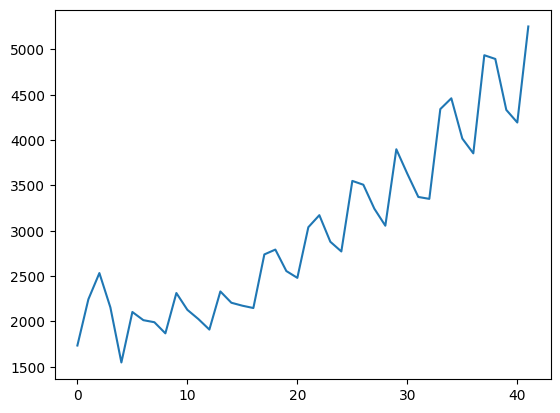

In [3]:
data = pd.read_excel("CocaCola_Sales_Rawdata.xlsx")
data.Sales.plot() 

## Moving average

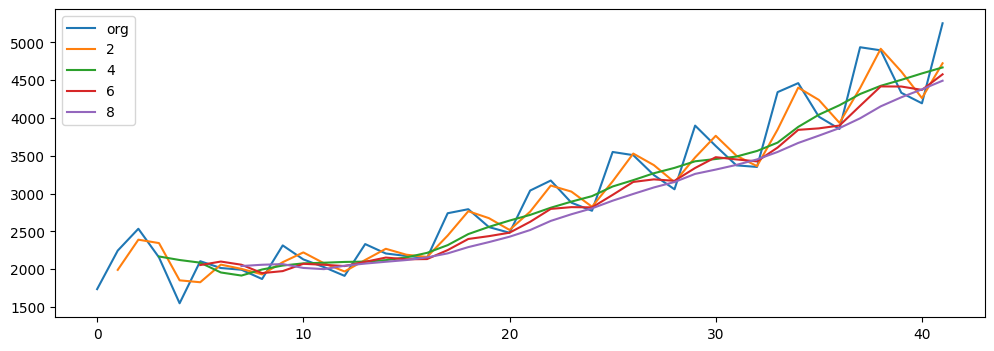

In [6]:
plt.figure(figsize=(12,4))
data.Sales.plot(label="org")
for i in range(2,10,2):
    data["Sales"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best') 

## Time series decomposition plot

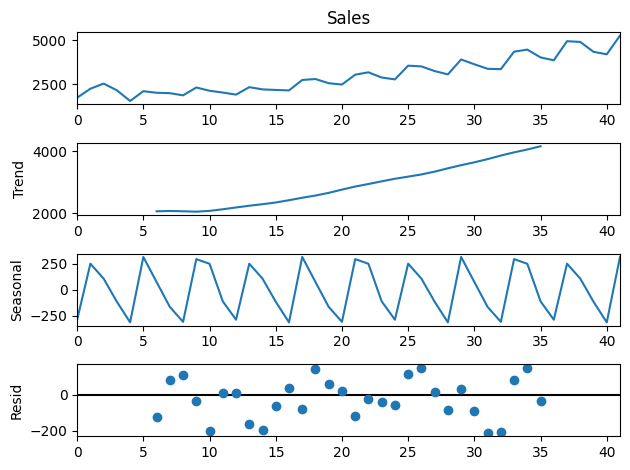

In [7]:
decompose_ts_add = seasonal_decompose(data.Sales,period=12)
decompose_ts_add.plot()
plt.show() 

A linearly increasing trend, with a seasonal component and some noise.

## ACF and PACF plots

D:\Anaconda\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


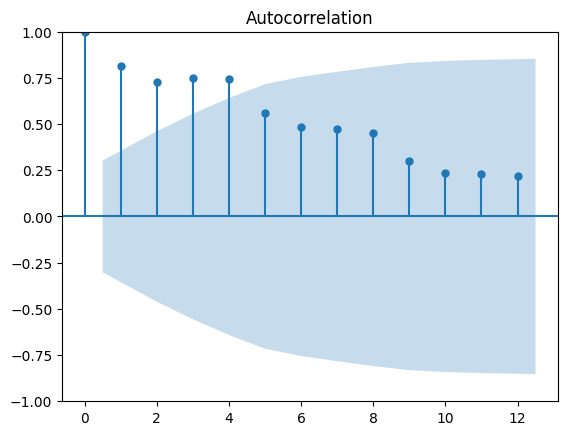

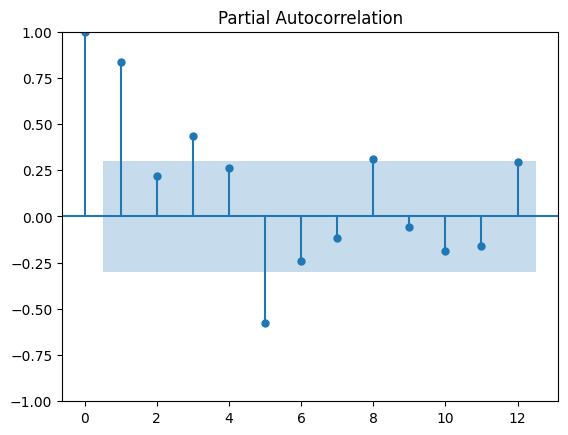

In [8]:
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(data.Sales,lags=12)
tsa_plots.plot_pacf(data.Sales,lags=12)
plt.show() 

The Auto Correlation Function (ACF) and Partial Auto Correlation Function (PACF) plots are used to determine which model will work best.

---------

Here in both the plots we can see some non-zero values at all the lags. So we will experiment with the above mentioned models and select the best one using the evaluation metric 'Mean Absolute Percentage Error'.

## Splitting the data

In [9]:
Train = data.head(29)
Test = data.tail(13) 

## Evaluation metric MAPE - Mean Absolute Percentage Error

In [10]:
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)  

## Simple exponential method

In [11]:
Train["Sales"] = Train["Sales"].astype('double') 
ses_model = SimpleExpSmoothing(Train["Sales"]).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_ses,Test.Sales) 

C:\Users\harivars\AppData\Local\Temp\ipykernel_4480\1226318661.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Train["Sales"] = Train["Sales"].astype('double')


25.763770604810425

## Holt method

In [12]:
hw_model = Holt(Train["Sales"]).fit(smoothing_level=0.2, smoothing_slope=0.15)
pred_hw = hw_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hw,Test.Sales)  

C:\Users\harivars\AppData\Local\Temp\ipykernel_4480\2826419091.py:1: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  hw_model = Holt(Train["Sales"]).fit(smoothing_level=0.2, smoothing_slope=0.15)


9.264019406632148

## Holts winter exponential smoothing with additive seasonality and additive trend

In [15]:
hwe_model_add_add = ExponentialSmoothing(Train["Sales"],seasonal="add",trend="add",seasonal_periods=4).fit() #add the trend to the model
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_add_add,Test.Sales)  

9.955888082141392

## Holts winter exponential smoothing with multiplicative seasonality and additive trend

In [16]:
hwe_model_mul_add = ExponentialSmoothing(Train["Sales"],seasonal="mul",trend="add",seasonal_periods=4).fit() 
pred_hwe_mul_add = hwe_model_mul_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_mul_add,Test.Sales) 

4.110036812247212

-----------------

From the above models, the Holt Winger exponential smoothing with multiplicative seasonality with additive trend gives the least error. So this model should be trained on the entire dataset to predict the Passengers for the next year.

## Training on the entire dataset

In [17]:
data["Sales"] = data["Sales"].astype('double')
hwe_model_mul_add = ExponentialSmoothing(data["Sales"],seasonal="mul",trend="add",seasonal_periods=4).fit()  

## Forecasting for the next 4 Quarters

In [20]:
pred_new = hwe_model_mul_add.forecast(4) 

In [56]:
pred_new = pd.DataFrame(pred_new, index=None)
pred_new = pred_new.reset_index()

In [19]:
new_data = {'Q3': [0, 0, 1, 0], 'Q4': [0, 0, 0, 1], 'Q1': [1, 0, 0, 0], 'Q2': [0, 1, 0, 0]}
predict_data = pd.DataFrame(new_data)

In [58]:
predict_data["Forecasted_Sales"] = pred_new.iloc[:, 1]
predict_data

,Q3,Q4,Q1,Q2,Forecasted_Sales
0,0,0,1,0,5210.523237
1,0,0,0,1,4772.600600
2,1,0,0,0,4517.616864
3,0,1,0,0,5694.128928
